In [52]:
import json
import os
from shapely import Polygon, MultiPolygon
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from collections import deque

In [25]:
def bfs_split_mask(mask):
    rows, cols, *_ = mask.shape
    binary_mask = np.zeros((rows, cols))
    binary_mask[mask[:, :, 3] > 0] = 1
    visited = np.zeros_like(binary_mask, dtype=bool)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    regions = []

    for r in range(rows):
        for c in range(cols):
            if binary_mask[r, c] == 1 and not visited[r, c]:
                region = np.zeros_like(binary_mask, dtype=np.uint8)
                queue = deque([(r, c)])
                visited[r, c] = True

                while queue:
                    x, y = queue.popleft()
                    region[x, y] = 1

                    for dx, dy in directions:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < rows and 0 <= ny < cols and binary_mask[nx, ny] == 1 and not visited[nx, ny]:
                            queue.append((nx, ny))
                            visited[nx, ny] = True

                regions.append(region)

    return regions

def regions_to_polygons(regions):
    polygons = []
    for region in regions:
        contours, _ = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            coords = [(point[0][0], point[0][1]) for point in contour]

            if len(coords) < 3:
                continue

            polygon = Polygon(coords)

            if polygon.is_valid and polygon.area > 0:
                polygons.append(polygon)
            elif polygon.buffer(0).is_valid:
                polygon = polygon.buffer(0)
                if isinstance(polygon, MultiPolygon):
                    for polygon_split in list(polygon.geoms):
                        polygons.append(polygon_split)
                else:
                    polygons.append(polygon.buffer(0))

    return polygons

def transform_point(point, H):
    point = np.array([*point, 1])
    transformed_point = np.dot(H, point)
    transformed_point /= transformed_point[2]
    return transformed_point[:2]

def transform_polygon(polygon, H, scale=1):
    transformed_points = [transform_point(p, H) * scale for p in np.array(polygon.exterior.coords)]
    return Polygon(transformed_points)

def filter_polygons(polygons: list[Polygon], min_size=5):
    return [p for p in polygons if p.area > min_size]

### Loading polygons

In [26]:
with open("parking_area.json", 'r') as poly_file:
    polygons_data = json.load(poly_file)

parking_polygons = [Polygon(xy) for xy in polygons_data.values()]

(-4.166072384351267, 38.64006789946807) (-16.050764714849418, 66.25641629867613)


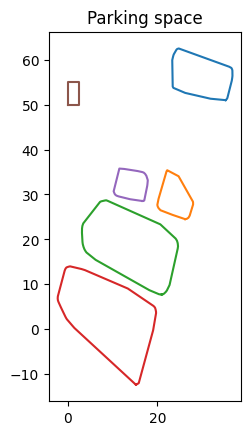

In [27]:
for poly in parking_polygons:
    plt.plot(*poly.exterior.xy)

example_parking_slot = Polygon([[0, 50], [2.5, 50], [2.5, 55], [0, 55]])
plt.plot(*example_parking_slot.exterior.xy)

plt.title("Parking space")
plt.axis('scaled')
plt.show()

### Detecting occupancy

In [28]:
info_path = r'C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\homography_info'
with open(os.path.join(info_path, 'info.json'), 'r') as info_file:
    homography_info = json.load(info_file)

H1 = np.load(os.path.join(info_path, homography_info['cameras']['weti1']['filename']))
H2 = np.load(os.path.join(info_path, homography_info['cameras']['weti2']['filename']))
H12 = np.load(os.path.join(info_path, homography_info['cameras']['weti1_weti2']['filename']))

homography = {
    'weti1': H1,
    'weti2': H2,
    'weti1_weti2': H12
}

In [49]:
occupancy_path = r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\segmentation\occupancy"
weti1_paths = [
    r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\segmentation\occupancy\weti1_2024_11_13_09_17_allowed.png",
    r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\segmentation\occupancy\weti1_2024_11_13_12_20_allowed.png",
]
weti2_paths = [
    r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\segmentation\occupancy\weti2_2024_11_13_09_17_allowed.png",
    r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\segmentation\occupancy\weti2_2024_11_13_12_20_allowed.png",
]
offx1, offy1 = homography_info['cameras']['weti1']['offset']
offx2, offy2 = homography_info['cameras']['weti2']['offset']
occ_weti1 = [cv2.imread(p, cv2.IMREAD_UNCHANGED)[offy1:, offx1:] for p in weti1_paths]
occ_weti2 = [cv2.imread(p, cv2.IMREAD_UNCHANGED)[offy2:, offx2:] for p in weti2_paths]

occ_weti1 = [regions_to_polygons(bfs_split_mask(o1)) for o1 in occ_weti1]
occ_weti2 = [regions_to_polygons(bfs_split_mask(o2)) for o2 in occ_weti2]

occ_weti1 = [[transform_polygon(poly, homography['weti1']) for poly in poly_list] for poly_list in occ_weti1]
occ_weti1 = [[transform_polygon(poly, homography['weti1_weti2']) for poly in poly_list] for poly_list in occ_weti1]
occ_weti2 = [[transform_polygon(poly, homography['weti2']) for poly in poly_list] for poly_list in occ_weti2]

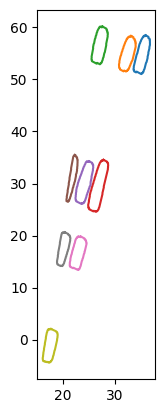

In [56]:
for o1 in occ_weti1[0]:
    plt.plot(*o1.exterior.xy)

plt.axis('scaled')
plt.show()

### Subtracting occupied area

In [181]:
def sub_polygons(base_polygon, sub_polygons):
    diff = base_polygon
    for sub_poly in sub_polygons:
        diff = diff.difference(sub_poly)
    return diff

def fix_multipolygons(polygons_list):
    polygons_list_fixed = []
    for poly in polygons_list:
        print(f"{poly=}")
        if isinstance(poly, MultiPolygon):
            for p in poly.geoms:
                polygons_list_fixed.append(p)
        else:
            polygons_list_fixed.append(poly)
    return polygons_list_fixed

def plot_poly(poly):
    if isinstance(poly, MultiPolygon):
        for p in poly.geoms:
            plt.plot(*p.exterior.xy)
            for inner in p.interiors:
                xi, yi = zip(*inner.coords[:])
                plt.plot(xi, yi, color="black")
    else:
        plt.plot(*poly.exterior.xy)
        for inner in poly.interiors:
            xi, yi = zip(*inner.coords[:])
            plt.plot(xi, yi, color="black")

In [154]:
# parking_polygons[3]
for p in occ_weti1[1]:
    print(min(p.exterior.xy[1]))

min(occ_weti1[1][-1].exterior.xy[1])

24.622142096287305
26.213059191972665
26.5863492757597
7.824719842557526
10.71839294623531
-12.062973638599276


-12.062973638599276

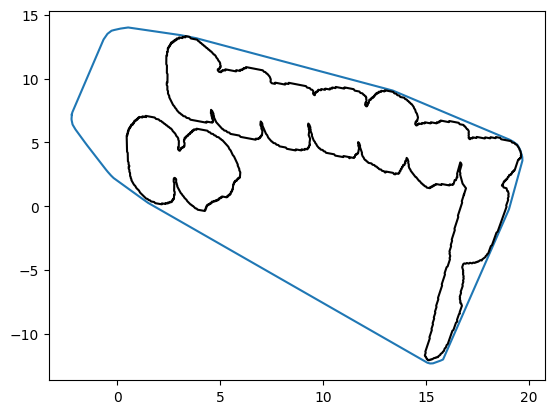

In [182]:
from descartes import PolygonPatch
pp = parking_polygons[3]
op = occ_weti1[0][-1]

pp = pp.difference(op)
for o in occ_weti1[1] + occ_weti2[1]:
    pp = pp - o
plot_poly(pp)

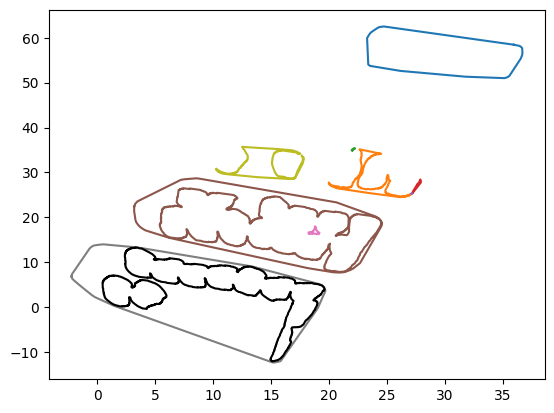

In [183]:
pps = [poly for poly in parking_polygons]
pps_sub = []
for pp in pps:
    for o in occ_weti1[1] + occ_weti2[1]:
        pp = pp - o
    pps_sub.append(pp)
    plot_poly(pp)

# for parking_poly in pps_sub:
#     if isinstance(parking_poly, MultiPolygon):
#         for p in parking_poly.geoms:
#             plt.plot(*p.exterior.xy)
#     elif isinstance(parking_poly, Polygon):
#         plt.plot(*parking_poly.exterior.xy)

# plt.axis('scaled')
# plt.show()

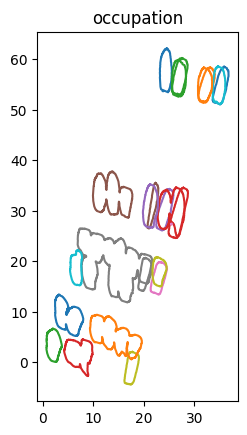

polies=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>
polies=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>
polies=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>
polies=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>
polies=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>


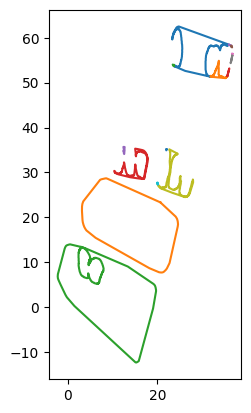

In [114]:
timestamp = 0
occupancies = occ_weti1[timestamp] + occ_weti2[timestamp]

for o in occupancies:
    plt.plot(*o.exterior.xy)
plt.axis('scaled')
plt.title("occupation")
plt.show()

parking_polygons_sub_v2 = [sub_polygons(parking_poly, occupancies) for parking_poly in parking_polygons]
for parking_poly in parking_polygons:
    poly = sub_polygons(parking_poly, occupancies)
    print(f"{polies=}")
    if isinstance(poly, MultiPolygon):
        for p in poly.geoms:
            plt.plot(*p.exterior.xy)
    elif isinstance(poly, Polygon):
        plt.plot(*poly.exterior.xy)

plt.axis('scaled')
plt.show()

poly=<MULTIPOLYGON (((25.427 58.739, 25.406 59.233, 25.348 59.503, 25.327 60.003,...>
poly=<MULTIPOLYGON (((22.314 28.83, 22.352 28.816, 22.378 28.956, 22.416 28.942, ...>
poly=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>
poly=<POLYGON ((3.074 13.4, 3.209 13.358, 3.208 13.256, 3.039 13.309, 3.038 13.20...>
poly=<MULTIPOLYGON (((12.49 34.449, 12.504 34.602, 12.477 34.771, 12.506 35.079, ...>


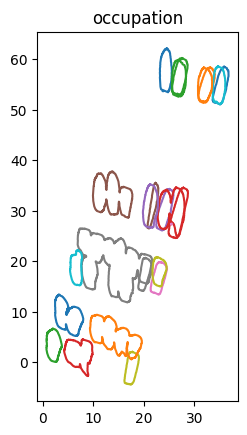

39.690929181518825 0.4295528740263951
2.6227731714295768 0.34781235703463564
2.2193962624499058e-15 0.9995272180556867
0.01944381564925295 1.0
0.006293919121162654 1.0
0.03740041767415953 0.6700561749543565
0.0013012856482593205 1.0
0.04171721093360541 0.9999999999999999
9.065422714762033 0.1781524424652802
0.0022140359195207374 0.9999999999999998
0.008204059449210786 0.7495442789413219
133.08863964540467 0.4720952202418406
196.45121529864562 0.6043993572892378
0.24635530135895542 0.8523611285052326
6.36085230725312 0.19625996057344927


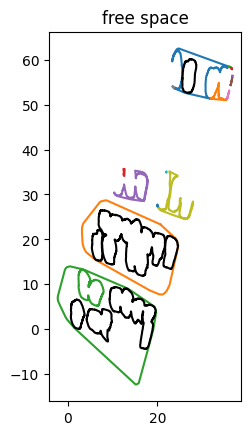

total free space area: 387.642762364768m^2, ~31.01142098918144 spaces


In [184]:
timestamp = 0
parking_polygons_sub = fix_multipolygons([sub_polygons(parking_poly, occ_weti2[timestamp] + occ_weti1[timestamp]) for parking_poly in parking_polygons])

for o in occ_weti1[timestamp] + occ_weti2[timestamp]:
    plt.plot(*o.exterior.xy)
plt.axis('scaled')
plt.title("occupation")
plt.show()

for poly in parking_polygons_sub:
    print(poly.area, poly.area / poly.convex_hull.area)
    # if poly.area > 5 * 2.5 * 0.8: #and poly.area / poly.convex_hull.area > 0.5:
    plot_poly(poly)

plt.axis('scaled')
plt.title("free space")
plt.show()

total_free_space = sum([poly.area for poly in parking_polygons_sub])
print(f"total free space area: {total_free_space}m^2, ~{total_free_space / (5*2.5)} spaces")